# Phase 1 - Binary classifier to predict in-hospital mortality

We propose to a two-phase model framework to predict in-hospital mortality and death time in hours. This notebook presents the machine learning pipeline for model training, hyperparameter tuning and model evaluation in Phase 1. In Phase 1, a binary classifier was trained to predict in-hospital mortality using the 123 features extracted from the previous stage of feature engineering in Hive. 

* Part 1. Define classes and methods for the machine learning pipieline
* Part 2. Model training and evaluation using 6-hour, 12-hour, 24-hour data
* Part 3. Visualization of ROC curves

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer, Imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import *
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---
## Part 1. Define classes and methods for the machine learning pipieline

First, we define the classes of `CustomLabelBinarizer`, `ItemSelector` and `MultiItemSelector` for custom data transformation in sklearn pipieline. Specifically, 
* `CustomLabelBinarizer` converts multi-class labels to binary labels.
* `ItemSelector` and `MultiItemSelector` select custom features from the input dataframe.

In [33]:
unseen_label = "__New__"
seed = 200

class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.le = LabelEncoder()
        self.lb = LabelBinarizer()
        self.seen_labels = set()
        
    def fit(self, x, y=None,**fit_params):
        self.seen_labels = set(x)
        self.seen_labels.add(unseen_label)
        
        # add "unseen" to X
        x_new = list(x)
        x_new.append(unseen_label)

        label_encoded = self.le.fit_transform(x_new)
        self.lb.fit(label_encoded)
        return self
    
    def transform(self, x):
        x_new = list(map(lambda label: label if label in self.seen_labels else unseen_label, list(x)))
        label_encoded = self.le.transform(x_new)
        return self.lb.transform(label_encoded)
    
    
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.key]

    
class MultiItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key_list):
        self.key_list = key_list

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.key_list]

Next, we define two useful methods `evaluate()` and `plot_roc()` for model evaluation. 
* `evaluate()` evaluates the model performance and prints a detailed report of the performance metrics e.g. accuracy, AUC score, precision, recall and F1 score.
* `plot_roc()` plots the ROC curve.

In [34]:
def evaluate(y_true, y_pred, y_pred_proba):
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1score = f1_score(y_true, y_pred)   
    print ("Accuracy : {:.4f}".format(acc))
    print("AUC score : {:.4f}".format(auc))
    print("Precision : {:.4f}".format(precision))
    print("Recall : {:.4f}".format(recall))
    print("F1 score : {:.4f}".format(f1score))
    print("\nClassification report : \n", classification_report(y_true, y_pred))
    print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))
    return acc, auc, precision, recall, f1score

def plot_roc(fpr, tpr, roc_auc):
    fig = plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Now, we are ready to define the main method `train_evaluate_model`. The method does the following:

* Split data into 80% training set and 20% test set
* Build custom machine learning pipeline which 
    * select specified features from the input dataframe (`ItemSelector` and `MultiItemSelector`) 
    * transform categorical data into binary label (`CustomLabelBinarizer`) 
    * impute missing values for numerical data with median (`Imputer`)
    * train `RandomForestClassifier` using `GridSearchCV` on 5-fold CV of the training set
    * find the best parameter set from the grid search
* Evaluate the model performance using the best parameter set on the test set
* Plot the ROC curve

Note that `hospital_expire_flag=1` indicates in-hospital mortality. We will train the classifier to predict this moratlity label. Also note that we have selected 123 extracted features covering 3 categorial variables and 120 numerical variables. 

In [4]:
def train_evaluate_model(df):
    
    # split data into 80% training set, 20% test set
    train_cv_df = df.sample(frac=0.8, random_state=seed)
    test_df = df.drop(train_cv_df.index)
    print(df.shape, train_cv_df.shape, test_df.shape)

    # define the machine learning pipeline
    discrete_pipeline = Pipeline([
        ("feature_union", FeatureUnion(
            transformer_list=[
                # categorical pipeline
                ('ethnicity', Pipeline([
                    ("selector", ItemSelector(key='ethnicity')),
                    ("binarizer", CustomLabelBinarizer())
                ])),            
                ("gender", Pipeline([
                    ("selector", ItemSelector(key='gender')),
                    ("binarizer", CustomLabelBinarizer())
                ])),
                ("admission_type", Pipeline([
                    ("selector", ItemSelector(key='admission_type')),
                    ("binarizer", CustomLabelBinarizer())
                ])),

                # numerical pipeline
                ("numerical", Pipeline([
                    ("selector", MultiItemSelector(key_list=
                          ['age', 'icustay_num',
                           'heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
                           'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean', 
                           'heartrate_min', 'sysbp_min', 'diasbp_min','meanbp_min', 
                           'resprate_min', 'tempc_min', 'spo2_min', 'glucose_min',
                           'heartrate_max', 'sysbp_max', 'diasbp_max', 'meanbp_max',
                           'resprate_max', 'tempc_max', 'spo2_max', 'glucose_max', 
                           'gcs_mean', 'gcsmotor_mean', 'gcsverbal_mean', 'gcseyes_mean', 'endotrachflag_mean',
                           'gcs_min', 'gcsmotor_min', 'gcsverbal_min', 'gcseyes_min', 'endotrachflag_min', 
                           'gcs_max', 'gcsmotor_max', 'gcsverbal_max', 'gcseyes_max', 'endotrachflag_max', 
                           'baseexcess_mean', 'carboxyhemoglobin_mean', 'methemoglobin_mean', 
                           'po2_mean', 'pco2_mean', 'ph_mean', 'pao2fio2ratio_mean', 'totalco2_mean', 
                           'aniongap_mean', 'albumin_mean', 'bands_mean', 'bicarbonate_mean', 
                           'bilirubin_mean', 'calcium_mean', 'creatinine_mean', 'chloride_mean', 
                           'hematocrit_mean', 'hemoglobin_mean', 'lactate_mean', 'platelet_mean', 
                           'potassium_mean', 'ptt_mean', 'inr_mean', 'sodium_mean', 'bun_mean', 'wbc_mean',
                           'baseexcess_min', 'carboxyhemoglobin_min', 'methemoglobin_min',
                           'po2_min', 'pco2_min', 'ph_min', 'pao2fio2ratio_min', 'totalco2_min',
                           'aniongap_min', 'albumin_min', 'bands_min', 'bicarbonate_min',
                           'bilirubin_min', 'calcium_min', 'creatinine_min', 'chloride_min',
                           'hematocrit_min', 'hemoglobin_min', 'lactate_min', 'platelet_min',
                           'potassium_min', 'ptt_min', 'inr_min', 'sodium_min', 'bun_min', 'wbc_min', 
                           'baseexcess_max', 'carboxyhemoglobin_max', 'methemoglobin_max', 
                           'po2_max', 'pco2_max', 'ph_max', 'pao2fio2ratio_max', 'totalco2_max',          
                           'aniongap_max', 'albumin_max', 'bands_max', 'bicarbonate_max', 
                           'bilirubin_max', 'calcium_max', 'creatinine_max', 'chloride_max', 
                           'hematocrit_max', 'hemoglobin_max', 'lactate_max', 'platelet_max', 
                           'potassium_max', 'ptt_max', 'inr_max', 'sodium_max', 'bun_max', 'wbc_max', 
                           'urineoutput'])),
                    # impute missing values with median
                    ("imputer", Imputer(strategy="median",
                                              axis=0)),
                ]))
            ]
        )),

        ("algorithm", RandomForestClassifier(n_jobs=-1))
    ])
    
    # define the parameter grid
    parameters = {'algorithm__n_estimators': [100, 250, 500],
                  'algorithm__max_features': ["auto", "sqrt", "log2"],
                  "algorithm__criterion": ["gini", "entropy"],
                  "algorithm__max_depth": [5, 10, 30],
                  "algorithm__bootstrap": [True, False]}

    # grid search on 5-fold CV, trained on 80% training set
    grid_search = GridSearchCV(discrete_pipeline, parameters, n_jobs=-1, verbose=1, refit=True, cv=5, scoring='roc_auc')
    grid_search.fit(train_cv_df, train_cv_df.hospital_expire_flag)

    # retrieve the best parameter set from grid search
    print("\nGrid Search Best parameters set :")
    print(grid_search.best_params_)
    print("\nBest score: %0.3f" % grid_search.best_score_)
    print("\nGrid scores :")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds,grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

    # evaluate model performance
    print("\nEvaluation on Training Set (80%) :")
    train_actual = train_cv_df.hospital_expire_flag
    train_pred = grid_search.predict(train_cv_df)
    train_pred_proba = grid_search.predict_proba(train_cv_df)[:,1]
    evaluate(train_actual, train_pred, train_pred_proba)

    print("\nEvaluation on Test Set (20%) :")
    test_actual = test_df.hospital_expire_flag
    test_pred = grid_search.predict(test_df)
    test_pred_proba = grid_search.predict_proba(test_df)[:,1]
    evaluate(test_actual, test_pred, test_pred_proba)

    # plot roc curve (using model result on test set)
    fpr, tpr, _ = roc_curve(test_actual, test_pred_proba)
    roc_auc = roc_auc_score(test_actual, test_pred_proba)
    plot_roc(fpr, tpr, roc_auc)
    
    return fpr, tpr, roc_auc

---
## Part 2. Model training and evaluation using 6-hour, 12-hour, 24-hour data
Now we have defined our custom machine learning pipeline, we are ready to fit the 6-hour, 12-hour and 24-hour data to the pipeline respectively.

In [5]:
# load 6-hour, 12-hour and 24-hour data extracted previously using Hive
df_6hr = pd.read_csv('../data/mp_data_6hr.csv')
df_12hr = pd.read_csv('../data/mp_data_12hr.csv')
df_24hr = pd.read_csv('../data/mp_data_24hr.csv')

print(df_6hr.shape, df_12hr.shape, df_24hr.shape)
df_6hr.head()

(49632, 131) (49632, 131) (49632, 131)


,subject_id,hadm_id,icustay_id,dbsource,expire_flag,hospital_expire_flag,deathtime_hours,hosp_deathtime_hours,age,gender,...,hemoglobin_max,lactate_max,platelet_max,potassium_max,ptt_max,inr_max,sodium_max,bun_max,wbc_max,urineoutput
0,3,145834,211552,carevue,1,0,5669.0,NaN,76.5246,M,...,10.1,8.0,221.5,4.05,52.35,1.7,141.5,42.0,15.2,20.0
1,4,185777,294638,carevue,0,0,NaN,NaN,47.8450,F,...,10.6,NaN,201.0,3.30,33.20,1.1,141.0,10.0,9.7,550.0
2,6,107064,228232,carevue,0,0,NaN,NaN,65.9398,F,...,9.2,NaN,330.0,4.80,41.20,1.1,134.0,65.0,10.6,760.0
3,9,150750,220597,carevue,1,1,107.0,118.0,41.7887,M,...,14.0,1.9,NaN,2.90,NaN,NaN,138.0,NaN,NaN,1450.0
4,11,194540,229441,carevue,1,0,5082.0,NaN,50.1476,F,...,12.6,NaN,258.0,3.90,NaN,NaN,141.0,14.0,9.3,400.0


In [8]:
# show all column names in df_6hr
for col in df_6hr.columns:
    print(col)

subject_id
hadm_id
icustay_id
dbsource
expire_flag
hospital_expire_flag
deathtime_hours
hosp_deathtime_hours
age
gender
ethnicity
admission_type
icustay_num
heartrate_mean
sysbp_mean
diasbp_mean
meanbp_mean
resprate_mean
tempc_mean
spo2_mean
glucose_mean
heartrate_min
sysbp_min
diasbp_min
meanbp_min
resprate_min
tempc_min
spo2_min
glucose_min
heartrate_max
sysbp_max
diasbp_max
meanbp_max
resprate_max
tempc_max
spo2_max
glucose_max
gcs_mean
gcsmotor_mean
gcsverbal_mean
gcseyes_mean
endotrachflag_mean
gcs_min
gcsmotor_min
gcsverbal_min
gcseyes_min
endotrachflag_min
gcs_max
gcsmotor_max
gcsverbal_max
gcseyes_max
endotrachflag_max
baseexcess_mean
carboxyhemoglobin_mean
methemoglobin_mean
po2_mean
pco2_mean
ph_mean
pao2fio2ratio_mean
totalco2_mean
aniongap_mean
albumin_mean
bands_mean
bicarbonate_mean
bilirubin_mean
calcium_mean
creatinine_mean
chloride_mean
hematocrit_mean
hemoglobin_mean
lactate_mean
platelet_mean
potassium_mean
ptt_mean
inr_mean
sodium_mean
bun_mean
wbc_mean
baseexcess_m

(49632, 131) (39706, 131) (9926, 131)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 49.2min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 64.5min finished



Grid Search Best parameters set :
{'algorithm__bootstrap': False, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 30, 'algorithm__max_features': 'log2', 'algorithm__n_estimators': 500}

Best score: 0.883

Grid scores :
0.831 (+/-0.014) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 100}
0.831 (+/-0.013) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 250}
0.831 (+/-0.012) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 500}
0.830 (+/-0.010) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'sqrt', 'algorithm__n_estimators': 100}
0.831 (+/-0.012) for {'algorithm__bootstrap': True, 'algo

Accuracy : 0.9998
AUC score : 1.0000
Precision : 1.0000
Recall : 0.9985
F1 score : 0.9992

Classification report : 
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     35087
          1       1.00      1.00      1.00      4619

avg / total       1.00      1.00      1.00     39706


Confusion matrix : 
 [[35087     0]
 [    7  4612]]

Evaluation on Test Set (20%) :
Accuracy : 0.9044
AUC score : 0.8827
Precision : 0.8194
Recall : 0.2214
F1 score : 0.3487

Classification report : 
              precision    recall  f1-score   support

          0       0.91      0.99      0.95      8779
          1       0.82      0.22      0.35      1147

avg / total       0.90      0.90      0.88      9926


Confusion matrix : 
 [[8723   56]
 [ 893  254]]


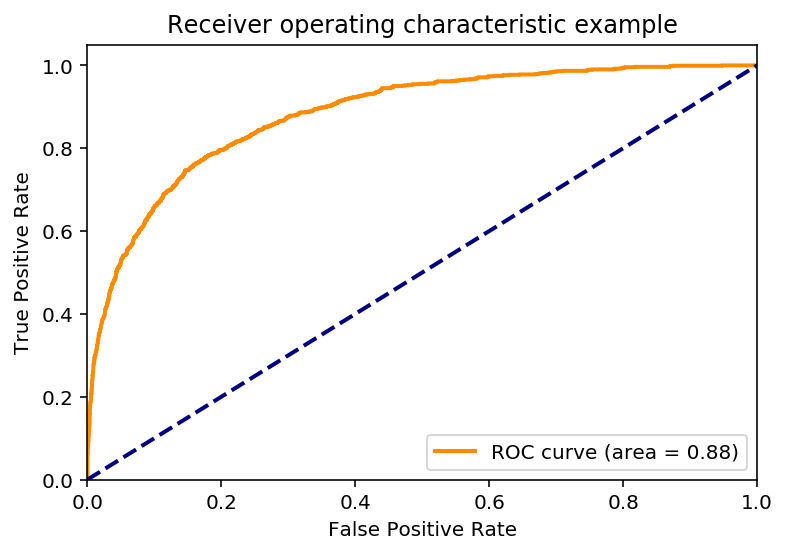

In [37]:
# use the following dictionary to store the model results trained on 6-hour, 12-hour and 24-hour data
fpr = {}  #false positive rate
tpr = {}  #true positive rate
roc_auc = {}  #auc score


# fit the pipeline and evaluate the model using 6-hour data
fpr[0], tpr[0], roc_auc[0] = train_evaluate_model(df_6hr)

(49632, 131) (39706, 131) (9926, 131)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 50.3min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 65.8min finished



Grid Search Best parameters set :
{'algorithm__bootstrap': False, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 30, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 500}

Best score: 0.901

Grid scores :
0.852 (+/-0.009) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 100}
0.854 (+/-0.009) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 250}
0.854 (+/-0.009) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 500}
0.853 (+/-0.010) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'sqrt', 'algorithm__n_estimators': 100}
0.854 (+/-0.009) for {'algorithm__bootstrap': True, 'algo

Accuracy : 1.0000
AUC score : 1.0000
Precision : 1.0000
Recall : 1.0000
F1 score : 1.0000

Classification report : 
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     35087
          1       1.00      1.00      1.00      4619

avg / total       1.00      1.00      1.00     39706


Confusion matrix : 
 [[35087     0]
 [    0  4619]]

Evaluation on Test Set (20%) :
Accuracy : 0.9126
AUC score : 0.9024
Precision : 0.8394
Recall : 0.3008
F1 score : 0.4429

Classification report : 
              precision    recall  f1-score   support

          0       0.92      0.99      0.95      8779
          1       0.84      0.30      0.44      1147

avg / total       0.91      0.91      0.89      9926


Confusion matrix : 
 [[8713   66]
 [ 802  345]]


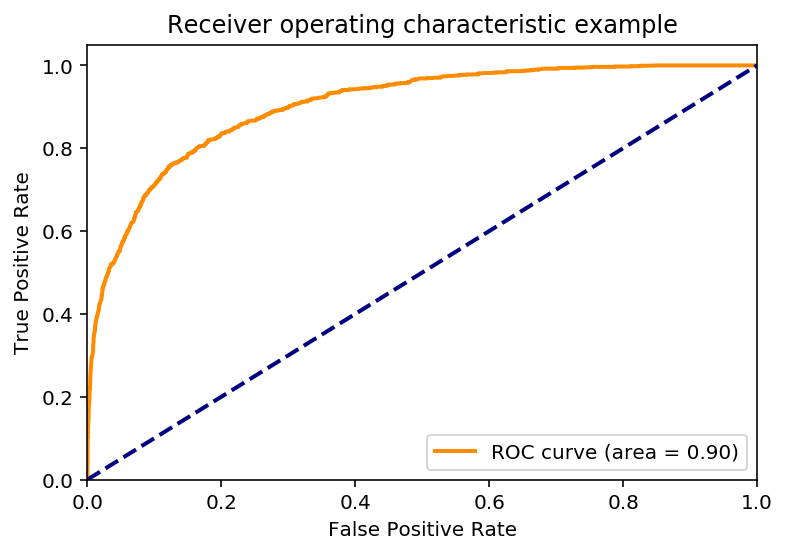

In [38]:
# fit the pipeline and evaluate the model using 12-hour data
fpr[1], tpr[1], roc_auc[1] = train_evaluate_model(df_12hr)

(49632, 131) (39706, 131) (9926, 131)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 52.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 68.3min finished



Grid Search Best parameters set :
{'algorithm__bootstrap': False, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 30, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 500}

Best score: 0.920

Grid scores :
0.877 (+/-0.006) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 100}
0.877 (+/-0.005) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 250}
0.878 (+/-0.006) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 500}
0.876 (+/-0.005) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'sqrt', 'algorithm__n_estimators': 100}
0.878 (+/-0.007) for {'algorithm__bootstrap': True, 'algo

Accuracy : 1.0000
AUC score : 1.0000
Precision : 1.0000
Recall : 1.0000
F1 score : 1.0000

Classification report : 
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     35087
          1       1.00      1.00      1.00      4619

avg / total       1.00      1.00      1.00     39706


Confusion matrix : 
 [[35087     0]
 [    0  4619]]

Evaluation on Test Set (20%) :
Accuracy : 0.9188
AUC score : 0.9191
Precision : 0.8324
Recall : 0.3723
F1 score : 0.5145

Classification report : 
              precision    recall  f1-score   support

          0       0.92      0.99      0.96      8779
          1       0.83      0.37      0.51      1147

avg / total       0.91      0.92      0.90      9926


Confusion matrix : 
 [[8693   86]
 [ 720  427]]


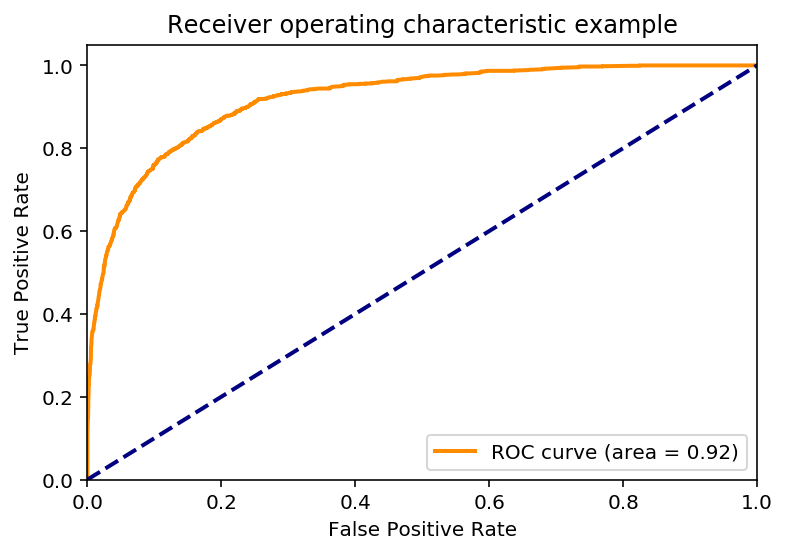

In [39]:
# fit the pipeline and evaluate the model using 24-hour data
fpr[2], tpr[2], roc_auc[2] = train_evaluate_model(df_24hr)

---
## Part 3. Visualization of ROC curves

Just now, we have trained random forest classifiers using 6-hour, 12-hour and 24-hour data respectively, and we have also stored the false positve rate, true positiive rate and AUC scores for each of these models. We can now compare and visualize their ROC curves on the test set.

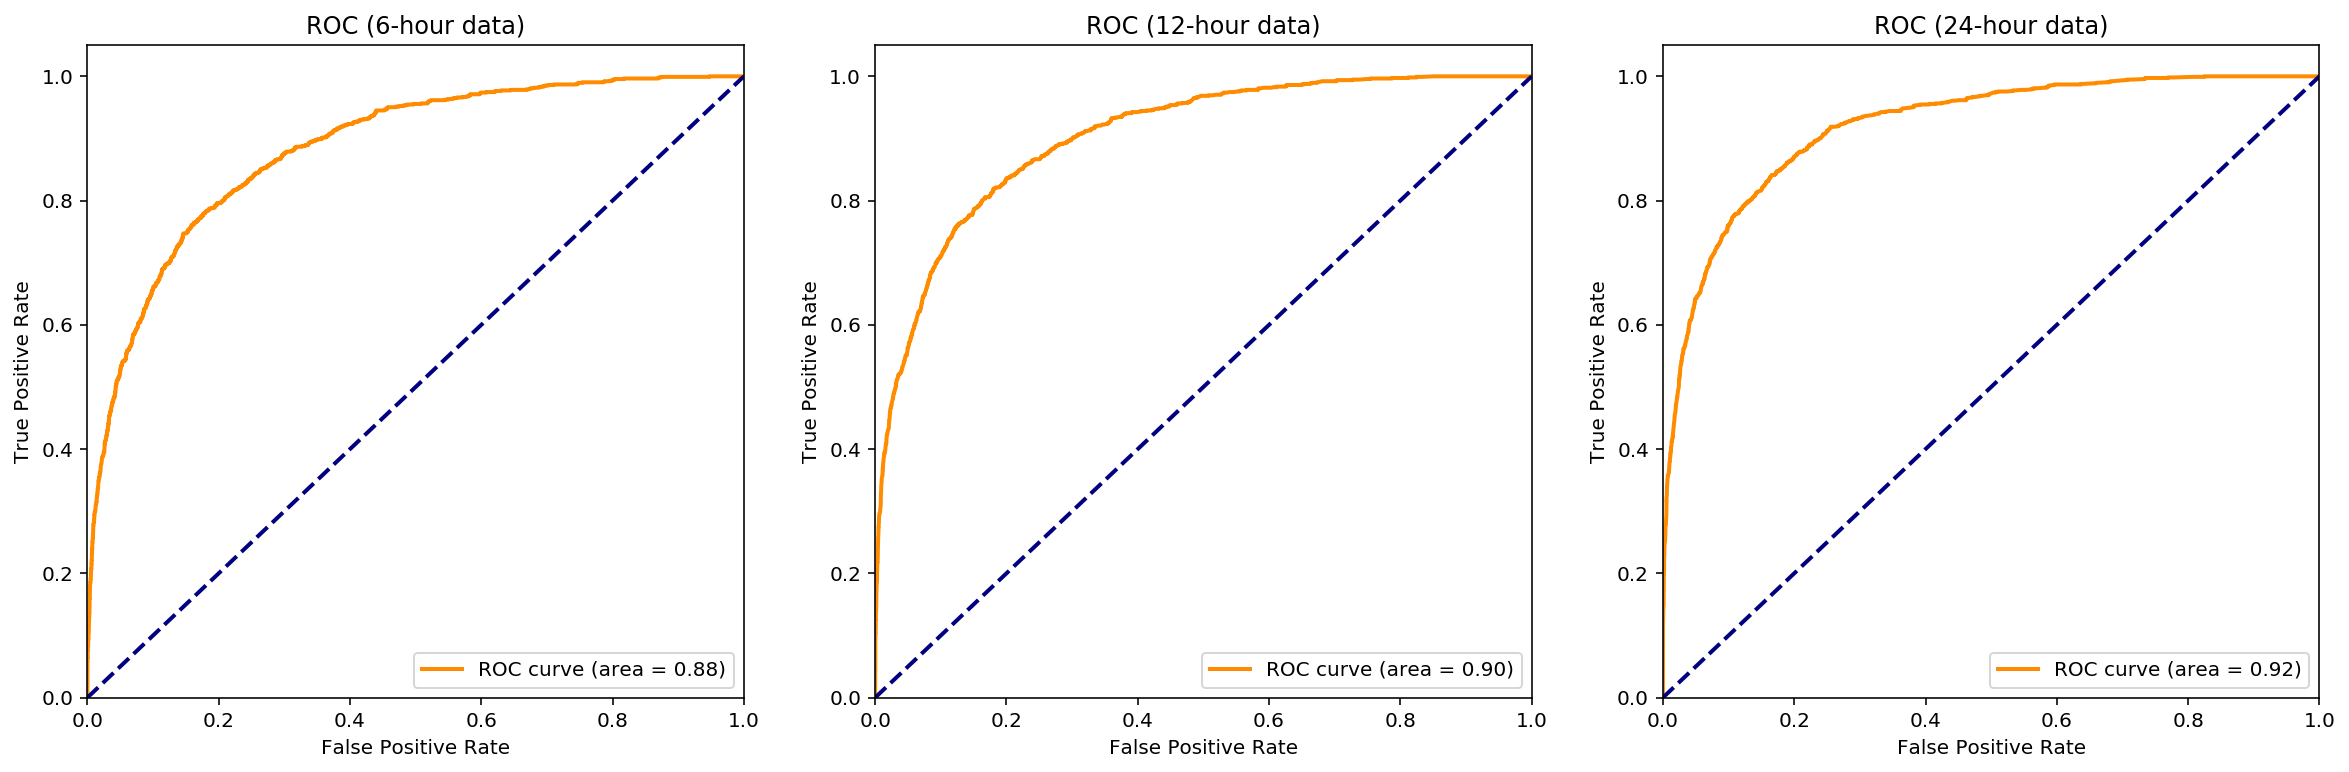

In [41]:
fig = plt.figure()
fig.set_size_inches(20,6)

plt.subplot(1,3,1)
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (6-hour data)')
plt.legend(loc="lower right")

plt.subplot(1,3,2)
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (12-hour data)')
plt.legend(loc="lower right")

plt.subplot(1,3,3)
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (24-hour data)')
plt.legend(loc="lower right")

fig.savefig('../img/figure2.png')
plt.show()